In [34]:
import os
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from PIL import Image
from plotly import tools
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
#PATH = 'F:/herbarium-2020_data/nybg2020/train/'
PATH = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/train/'
OPEN_DIR = os.listdir(PATH)
DIR_TRAIN = PATH+OPEN_DIR[0]
META_DATA = PATH+OPEN_DIR[1]

In [36]:
with open(META_DATA, 'r') as json_file:
    data = json.load(json_file)
    for key in data:
        print("-",key, len(data[key]))

- annotations 1030747
- categories 32094
- images 1030747
- info 6
- licenses 1
- regions 4


In [37]:
df_images = pd.DataFrame(data['images'])
df_categories = pd.DataFrame(data['categories'])
df_annotations = pd.DataFrame(data['annotations'])

In [38]:
df_images.head(3)

,file_name,height,id,license,width
0,images/156/72/354106.jpg,1000,354106,1,661
1,images/115/24/818566.jpg,1000,818566,1,661
2,images/115/24/750704.jpg,1000,750704,1,661


In [39]:
df_annotations.head(3)

,category_id,id,image_id,region_id
0,15672,354106,354106,1
1,11524,818566,818566,1
2,11524,750704,750704,1


In [40]:
assert len(df_annotations) == len(df_images)
df_images_annotations = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id', how='right').drop('image_id', axis=1)
df_images_annotations = df_images_annotations.sort_values(['category_id'])

In [41]:
df_images_annotations.head(4)

,file_name,height,id_x,license,width,category_id,id_y,region_id
76407,images/000/00/626762.jpg,1000,626762,1,681,0,626762,1
601590,images/000/00/72077.jpg,1000,72077,1,681,0,72077,1
76408,images/000/00/818271.jpg,1000,818271,1,681,0,818271,1
556748,images/000/00/495523.jpg,1000,495523,1,681,0,495523,1


In [42]:
df_images_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030747 entries, 76407 to 479781
Data columns (total 8 columns):
file_name      1030747 non-null object
height         1030747 non-null int64
id_x           1030747 non-null int64
license        1030747 non-null int64
width          1030747 non-null int64
category_id    1030747 non-null int64
id_y           1030747 non-null int64
region_id      1030747 non-null int64
dtypes: int64(7), object(1)
memory usage: 70.8+ MB


## ======= Count sample per category ========

In [43]:
groups = df_images_annotations.groupby('category_id')
dict_infos = []
for i in range(len(groups)):
#     print('Category = %s | Count samples per category = %s' % (groups.get_group(i).set_index('file_name')['category_id'][0], len(groups.get_group(i).set_index('file_name'))))
    if i != 23079:
        dic = {'category':groups.get_group(i).set_index('file_name')['category_id'][0], 'nb_samples':len(groups.get_group(i).set_index('file_name'))}
        dict_infos.append(dic)

In [44]:
# df_infos = pd.DataFrame(dict_infos, index=None)
# df_infos.to_csv('C:/Users/hamza/HerbariumKaggle/sample_per_category.csv',index=False, sep=';')

## =============== End ===============

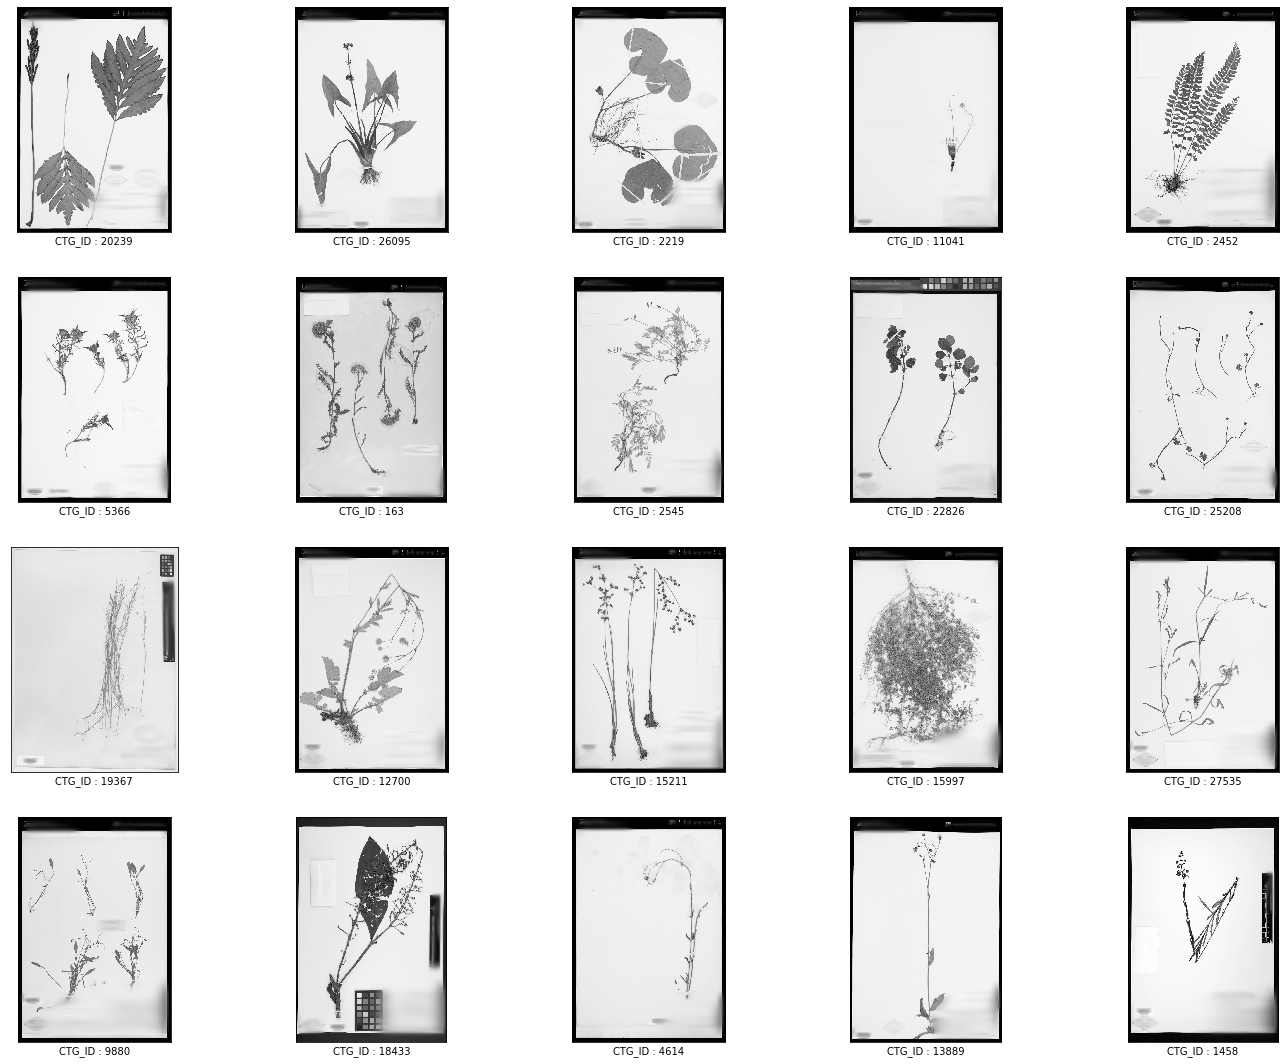

In [45]:
def plot_samples(df, size=(22,22), nb_samples=20, cmap=False):
    
    plt.figure(figsize=size)
    for i in range(nb_samples):
        random_sample = df.iloc[np.random.random_integers(i,len(df) - 1)]
        
        if cmap:
            random_sample_img = Image.open(PATH+random_sample['file_name']).convert("L")
        else:
            random_sample_img = mpimg.imread(PATH+random_sample['file_name'])
            
        arr = np.asarray(random_sample_img)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        if cmap:
            plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(random_sample_img, cmap=plt.cm.binary)
            
        plt.xlabel("CTG_ID : "+str(random_sample['category_id']))
    plt.show()
    
plot_samples(df_images_annotations, size=(24,24), nb_samples=20, cmap="gray")

In [46]:
df_sampels = df_images_annotations[['file_name', 'category_id']]
# df_sampels.to_csv('sample.csv' , index=False, sep=";")
df_sampels.head(4)

,file_name,category_id
76407,images/000/00/626762.jpg,0
601590,images/000/00/72077.jpg,0
76408,images/000/00/818271.jpg,0
556748,images/000/00/495523.jpg,0


In [47]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(list(df_sampels.file_name[0:4000]), list(df_sampels.category_id[0:4000]), test_size = 0.1, random_state = 0)

In [48]:
len(x_train),len(x_test)
print(x_train[0])

images/000/31/627976.jpg


In [49]:
x_train[0], y_train[0]

('images/000/31/627976.jpg', 31)

In [50]:
'''
print(x_train.shape)
print(x_test.shape)
print()
print(y_train.shape)
print(y_test.shape)
'''

'\nprint(x_train.shape)\nprint(x_test.shape)\nprint()\nprint(y_train.shape)\nprint(y_test.shape)\n'

## ======================= MODEL START =======================

In [51]:
def read_images(x, y, resize_to=(128, 128)):
    
    images = []
    labels = []    
    
    for i, image in enumerate(x):
        
        im = Image.open(PATH+image)
        im = im.resize(resize_to)
        im = np.array(im) / 255.0
        im = im.astype("float32")
        images.append(im)
       
        labels.append(y[i])
    
    
    return np.array(images), np.array(labels)

x_train, y_train = read_images(x_train, y_train, resize_to=(64, 64))
x_test, y_test = read_images(x_test, y_test, resize_to=(64, 64))

print(type(x_train))
print("\t- NB TRAIN SAMPLES %s WIDTH %s HEIGHT %s COLOR %s" % (x_train.shape))
print("\t- NB TEST SAMPLES %s WIDTH %s HEIGHT %s COLOR %s" % (x_test.shape))

<class 'numpy.ndarray'>
	- NB TRAIN SAMPLES 3600 WIDTH 64 HEIGHT 64 COLOR 3
	- NB TEST SAMPLES 400 WIDTH 64 HEIGHT 64 COLOR 3


In [52]:
def one_hote_encoding(y_train, y_test):
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    return y_train, y_test

y_train, y_test = one_hote_encoding(y_train, y_test)
print(len(y_train))
print(x_train.shape)
print(x_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

3600
(3600, 64, 64, 3)
(400, 64, 64, 3)

(3600, 151)
(400, 151)


In [53]:
def hyperParams():
        
    # with linear        
    modelParams = {"Layers":[
#                     {"neurons":1 , "activation":"tanh", "dropOut":False},
                    {"neurons":151, "activation":"softmax", "dropOut":False}
                    ],
                   "loss":"categorical_crossentropy",
                   "optimizer":"SGD(lr=0.001)",
                   "metrics":"accuracy",
                   "learningRate":.001,
                   "epochs":120,
                   "batchSize":50,
                   "testName":"Simple Linear Model"
                 }
    
    # with MLP
#     modelParams = {"Layers":[
#                     {"neurons":1024 , "activation":"relu", "dropOut":False},
#                     {"neurons":512 , "activation":"relu", "dropOut":False},
#                     {"neurons":256 , "activation":"relu", "dropOut":False},
#                     {"neurons":151, "activation":"softmax", "dropOut":False}
#                     ],
#                    "loss":"categorical_crossentropy",
#                    "optimizer":"Adam(lr=0.001)",
#                    "metrics":"accuracy",
#                    "learningRate":.0001,
#                    "epochs":120,
#                    "batchSize":50,
#                    "testName":"Simple Linear Model"
#                  }
    return modelParams


In [54]:
def createModel(params):
    
    model = Sequential()
    model.add(Flatten(input_shape=(64,64,3)))
    for layers in params['Layers']:
        if layers['dropOut'] == False:
            model.add(Dense(layers['neurons'], activation=layers['activation']))
        else:
            model.add(Dense(layers['neurons'], activation=layers['activation']))
            model.add(Dropout(layers['dropOut']))
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss=params['loss'],
                   optimizer=opt,
                   metrics=['accuracy'])
    
    model.summary()
    return model

In [55]:
def reshapeInput(x_train, x_test):
    
    x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3]) #
    x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3]) #
    
    return x_train, x_test

x_train, x_train = reshapeInput(x_train, x_train)

In [56]:
def fitModel(model, params, x_train, y_train, x_test, y_test):
    
#     start_time = time.time()
#     tensorboard = TensorBoard(log_dir='D:\logsProject\{}'.format(logName()))
    ################################ CALCULATE RUNTIME - START ###############################
    history = model.fit(x_train, y_train,
                       epochs=params['epochs'],
                       batch_size=params['batchSize'], verbose=1, validation_data=(x_test, y_test))
    ################################ CALCULATE RUNTIME - END ###############################

    return model, history

In [57]:
def evaluateModel(model, x_test, y_test):
    
    return model.evaluate(x_test, y_test, batch_size=50)

In [58]:
def predictionPercent(model, x_test, y_test):
    
    prediction = model.predict(x_test)
    predicted = []
    for i in range(len(prediction)):
        if np.argmax(y_test[i]) == np.argmax(prediction[i]):
            predicted.append(1)
        else:
            predicted.append(0)
    print("Predicted percent {} %".format((sum(predicted)/(len(predicted)) * 100)))
    result = (sum(predicted)/len(predicted)) * 100
    
    return prediction, result

In [59]:
def plotPredictedResult(prediction, x_test, y_test):
    
    plt.figure(figsize=(15, 15))
    for i in range(20):
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[i])
        plt.xlabel("True: "+str(np.argmax(y_test[i]))+"\n\n\n")
        plt.title("\nPredicted: "+str(np.argmax(prediction[i])))
        
    plt.show()

In [60]:
def trace(x,y,imagesLabels,color):
        trace = go.Scatter(
            x = x,y = y,
            name=imagesLabels,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plotAccLoss(model):
    
    hist = model.history
    acc = hist['accuracy']
    valAcc = hist['val_accuracy']
    loss = hist['loss']
    valLoss = hist['val_loss']

    epochs = list(range(1,len(acc)+1))

    traceA = trace(epochs,acc,"Training accuracy", "Green")
    traceVa = trace(epochs,valAcc,"Validation accuracy", "Red")
    traceL = trace(epochs,loss,"Training loss", "Blue")
    traceVl = trace(epochs,valLoss,"Validation loss", "Magenta")

    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(traceA,1,1)
    fig.append_trace(traceVa,1,1)
    fig.append_trace(traceL,1,2)
    fig.append_trace(traceVl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])


    iplot(fig, filename='accuracy-loss')

================================ GENERATE PARAMS ================================
================================ CREATE MODEL ================================
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 151)               38807     
Total params: 13,278,871
Trainable params: 13,278,871
Non-trainable params: 0
_____________

Epoch 101/120
3600/3600 [==============================] - 1s 173us/sample - loss: 2.5681 - accuracy: 0.3703 - val_loss: 2.8196 - val_accuracy: 0.2750
Epoch 102/120
3600/3600 [==============================] - 1s 171us/sample - loss: 2.5593 - accuracy: 0.3683 - val_loss: 2.7969 - val_accuracy: 0.2700
Epoch 103/120
3600/3600 [==============================] - 1s 171us/sample - loss: 2.5592 - accuracy: 0.3733 - val_loss: 2.7951 - val_accuracy: 0.2925
Epoch 104/120
3600/3600 [==============================] - 1s 170us/sample - loss: 2.5412 - accuracy: 0.3769 - val_loss: 2.7814 - val_accuracy: 0.2850
Epoch 105/120
3600/3600 [==============================] - 1s 171us/sample - loss: 2.5425 - accuracy: 0.3700 - val_loss: 2.7813 - val_accuracy: 0.3000
Epoch 106/120
3600/3600 [==============================] - 1s 172us/sample - loss: 2.5310 - accuracy: 0.3753 - val_loss: 2.7870 - val_accuracy: 0.2800
Epoch 107/120
3600/3600 [==============================] - 1s 172us/sample - loss: 2.5228 - ac

================================ EVALUATE MODEL ================================
400/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

================================ PREDICITION ================================
Predicted percent 31.0 %
================================ PLOT PREDICITION ================================


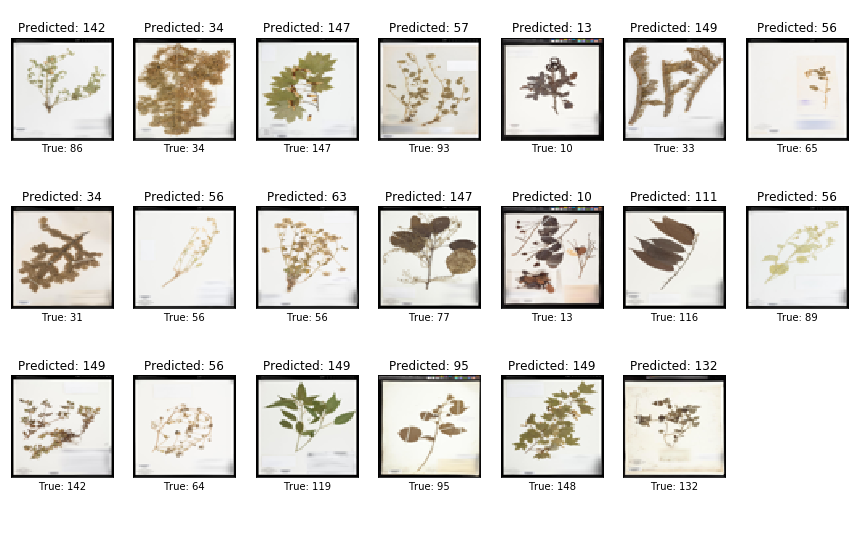

In [61]:
global ID
ID = random.randint(1,1000000)
    
print("================================ GENERATE PARAMS ================================")
params = hyperParams()

print("================================ CREATE MODEL ================================")
model = createModel(params)

plot_model(model, "model_"+str(ID)+"_.png")

print("================================ RESHAPE INPUTS ================================")
x_train, x_test = reshapeInput(x_train, x_test)

print("================================ FIT MODEL ================================")
model, history = fitModel(model, params, x_train, y_train, x_test, y_test)

print("================================ PLOT ACCURACY AND LOSS ================================")
plotAccLoss(history)

print("================================ EVALUATE MODEL ================================")
resultEV = evaluateModel(model, x_test, y_test)

print("================================ PREDICITION ================================")
prediction, result = predictionPercent(model, x_test, y_test)

print("================================ PLOT PREDICITION ================================")
plotPredictedResult(prediction, x_test, y_test)

In [29]:
model.save('explore_linear_model.h5')

In [30]:
DIR_TEST = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/test/'
DIR_TRAIN = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/train/'
META_DATA_TRAIN = DIR_TRAIN+'metadata.json'
META_DATA_TEST = DIR_TEST+'metadata.json'

In [31]:
# load all data again with new method, checking real predict
with tf.device("/cpu:0"):
    with open(META_DATA_TRAIN, 'r') as json_file:
        data_train = json.load(json_file)
        for key in data_train:
            print("-",key, len(data_train[key]))
    print("================================")
    with open(META_DATA_TEST, 'r') as json_file2:
        data_test = json.load(json_file2)
        for key in data_test:
            print("-",key, len(data_test[key]))

- annotations 1030747
- categories 32094
- images 1030747
- info 6
- licenses 1
- regions 4
- images 138292
- info 6
- licenses 1


In [32]:
with tf.device("/cpu:0"):
    df_images = pd.DataFrame(data_test['images']).drop('height', axis=1).drop('width', axis=1).drop('license', axis=1)
    display(df_images.head(3))

,file_name,id
0,images/104/104891.jpg,104891
1,images/018/18029.jpg,18029
2,images/035/35151.jpg,35151


In [33]:
with tf.device("/cpu:0"):
    
    #import tensorflow.keras.backend as K
    #K.set_floatx('float16')

    batch_size = 320
    train_model = tf.keras.models.load_model('explore_linear_model.h5')

    test_datagen = ImageDataGenerator(featurewise_center=False,
                                      featurewise_std_normalization=False)#, dtype='float16')

#     print(df_images.dtypes)
#     df_images.astype("float16")
#     print(type(df_images))

    generator = test_datagen.flow_from_dataframe(
            dataframe = df_images,#df_images.iloc[:500],#df_images, #Limiting the test to the first 10,000 items
            directory = DIR_TEST,
            x_col = 'file_name',
            target_size=(64, 64),
            batch_size=batch_size,
            class_mode=None,  # only data, no labels
            shuffle=False)

    category = train_model.predict_generator(generator, verbose=1)#.astype("float16")
    print(type(category[0][0]))

Found 138292 validated image filenames.
101/433 [=====>........................] - ETA: 31:26

KeyboardInterrupt: 

In [ ]:
sub = pd.DataFrame()
sub['Id'] = df_images.id
sub['Id'] = sub['Id'].astype('int32')

sub['Predicted'] = np.concatenate([np.argmax(category, axis=1), 23718*np.ones((len(df_images.id)-len(category)))], axis=0)
sub['Predicted'] = sub['Predicted'].astype('int32')
display(sub)
sub.to_csv(name_of_model+'_category_submission.csv', index=False)
print("nombres de classes différentes prédites :", sub['Predicted'].nunique())